# **KalMax**

In this script we demonstrate how to use the KalMax library. We will: 

0. Load/generate some exemplar spiking and trajectory data .
1. Fit KDE receptive fields to the spiking data.
2. Run inference by: 
    1. Estimate likelihood maps 
    2. Kalman filter (and smooth) these


In [1]:
# Dependencies
from jax import numpy as jnp
from jax import vmap 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
# set default matplotlib color cycle
# matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["#008bf8","#04e762","#f5b700","#89fc00","#dc0073"],)

# Kalmax
import kalmax
from kalmax.KalmanFilter import KalmanFilter, fit_parameters
from kalmax.KDE import kde
from kalmax.utils import make_simulated_dataset, fit_gaussian

%load_ext autoreload
%autoreload 2

## 0. Generate data

The data is are:

* $\mathbf{s}_t \in \mathbb{N}^N$  is the vector of spike counts for all neurons at time $t$.
* $\mathbf{z}_t \in \mathbb{R}^D$ is the position (more generally the "latent variable") at time $t$.

These are concatenated into data arrays: $ \mathbf{S} \in \mathbb{N}^{T \times N} $ and $ \mathbf{Z} \in \mathbb{R}^{T \times D} $



In [2]:
#GLOBALS
TIME_MINS = 20 # total amount of data in minutes
TEST_FRAC = 0.1 # fraction of data to use for testing
N_CELLS = 100 # number of cells in the simulated dataset
FIRING_RATE = 10 # max firing rate of the simulated cells

In [3]:
# Data generation
T, Z, S = make_simulated_dataset(time_mins = TIME_MINS, 
                                 n_cells = N_CELLS,
                                 firing_rate = FIRING_RATE,) #alternatively you can load some real data here
print(f"Shapes:\n  •Time, T {T.shape}\n  •Trajectory, Z: {Z.shape}\n  •Spikes, S: {S.shape}")
N_CELLS = S.shape[1]
DIMS = Z.shape[1]
DT = T[1] - T[0]

# Split data into training and testing
train_id = jnp.argmin(jnp.abs(T - TIME_MINS * (1 - TEST_FRAC) * 60))
T_train, T_test = T[:train_id], T[train_id:]
S_train, S_test = S[:train_id], S[train_id:]
Z_train, Z_test = Z[:train_id], Z[train_id:]

100%|██████████| 12000/12000 [00:03<00:00, 3044.83it/s]


Shapes:
  •Time, T (12000,)
  •Trajectory, Z: (12000, 2)
  •Spikes, S: (12000, 100)


### Pad the data, calculate it's extent and discretise the domain

We generate a grid of position coordinates bins spanning the D-dimensional domain of the latent space. These are the bins over which we will estimate the receptive fields. We flattened them into a list but record the original shape for when we later want to visualise the receptive fields. (You may adapt this to a D $\neq$ 2-dimensional latent accordingly)

* `bin_positions` is an array of positions shape `(N_bins, D)` spanning the full domain of the data (plus a little bit). 
* `bin_shape` is a tuple `(n_x_bins, n_y_bins)` for reshapping the grid_positions array into a grid.


In [4]:
# GLOBALS
DX = 0.01 # resolution of receptive field estimates in meters
PAD = 0.1 # padding around the trajectory in meters

In [5]:
# Get max and min data positions
min_x, max_x, min_y, max_y = Z_train[:,0].min(), Z_train[:,0].max(), Z_train[:,1].min(), Z_train[:,1].max()
width_x, width_y = max_x - min_x, max_y - min_y

# Make a grid of positions to evaluate the receptive fields
x = jnp.arange(min_x-PAD, max_x+DX+PAD, DX) 
y = jnp.arange(min_y-PAD, max_y+DX+PAD, DX)
x_mg, y_mg = jnp.meshgrid(x, y) # Y is the first dimension, X is the second dimension (for plotting)
env_extent = (x.min()-DX/2, x.max()+DX/2, y.min()-DX/2, y.max()+DX/2) # for plotting

# Get the bin positions and shapes
bin_shape = x_mg.shape # so we can reshape the receptive fields later
bin_positions = jnp.stack([x_mg.ravel(), y_mg.ravel()], axis=1) # x is first coordinate, y is second coordinate

In [6]:
max_x-min_x

Array(0.999021, dtype=float32)

Plot the spikes against trajectory to see the data.

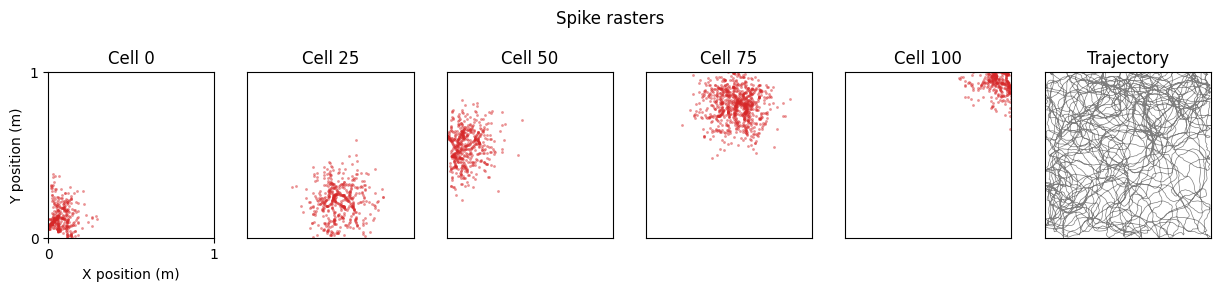

In [7]:
fig = plt.figure(figsize=(15, 3))
for (i,n) in enumerate(np.linspace(0,N_CELLS,5,dtype=int)):
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    ax.scatter(Z_train[:,0][S_train[:,n] > 0], Z_train[:,1][S_train[:,n] > 0], s=4, linewidth=0, alpha=0.5, c='C3')
    ax.set_title(f"Cell {n}")
    ax.set_xlim(min_x, max_x); ax.set_ylim(min_y, max_y); ax.set_aspect('equal', 'box')
    if i == 0:
        ax.set_xticks([min_x.round(1), max_x.round(1)]); ax.set_yticks([min_y.round(1), max_y.round(1)])
        ax.set_xlabel("X position (m)"); ax.set_ylabel("Y position (m)")
fig.suptitle("Spike rasters")

ax = fig.add_subplot(1, 6, i+2, xticks=[], yticks=[])
# dots and lines
ax.plot(Z_train[:,0], Z_train[:,1], c='k', alpha=0.5, lw=0.5)
ax.set_xlim(min_x, max_x); ax.set_ylim(min_y, max_y); ax.set_aspect('equal', 'box')
ax.set_title("Trajectory");
fig.savefig("figures/data.png")

## 1. **KDE** to fit receptive fields 

We will use **kernel density estimation** to fit the receptive fields. KDE is a way of converting discrete events to smooth functions.

Let $\mathbf{f}(\mathbf{z}) = [f_1(\mathbf{z}), \cdots f_1(\mathbf{z})]^{\mathsf{T}}$ be the vector of _expected_ spike counts for each neuron at position $\mathbf{z}$ (i.e. the receptive fields) which we want to estimate from the data.


The KDE estimate of the receptive field for neuron $i$ is:
$$f_i(\mathbf{z}) = \frac{\sum_{t_s} K(\mathbf{z}, \mathbf{z}_{t_s}) }{\sum_{t} K(\mathbf{z}, \mathbf{z}_{t})}$$
where $t_s$ are the times when neuron $i$ spiked.
The basic idea is that the _expected_ number of spikes is the no. of spikes at that location x divided by the total no. of visits to that location. 

$K(\mathbf{z}, \mathbf{z}^{\prime})$ is any kernel function. We will use a Gaussian with covariance $\boldsymbol{\Sigma} = \sigma^2 \mathbf{I}$:

$$K_{\textrm{Gaussian}}(\mathbf{z}, \mathbf{z}^{\prime}) = \frac{1}{(2\pi)^{D/2} |\boldsymbol{\Sigma}|^{1/2}} \exp\left(-\frac{1}{2} (\mathbf{z} - \mathbf{z}^{\prime})^{\mathsf{T}} \boldsymbol{\Sigma}^{-1} (\mathbf{z} - \mathbf{z}^{\prime})\right)$$

Now we estimate the receptive fields by passing the bins, the trajectory and the spikes and a kernel into the `KDE.kde()` function.

In [8]:
# GLOBALS
KERNEL_WIDTH = 0.02 # width of the smoothing kernel in meters
KERNEL = kalmax.kernels.gaussian_kernel # the kernel function - you can write your own but it must follow a certain signature
KERNEL_KWARGS = {'covariance':KERNEL_WIDTH**2*np.eye(DIMS)}

In [9]:
# Calculate the firing rate of all cells at all grid positions
firing_rate = kde(
    bins = bin_positions,
    trajectory = Z_train,
    spikes = S_train,
    kernel = KERNEL,
    kernel_kwargs = KERNEL_KWARGS,
)

# Reshape into receptive fields and divide by DT to get spikes per second (not per bin) 
firing_rate_maps = firing_rate.reshape((N_CELLS,)+bin_shape) / DT 

Now lets plot a few to check they look like place cells

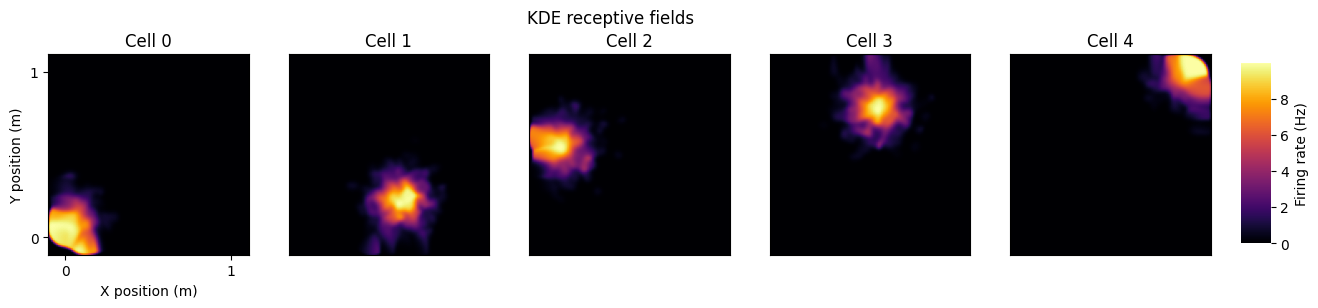

In [10]:
# Plot the smoothed receptive fields 
fig = plt.figure(figsize=(15, 3))
for (i,n) in enumerate(np.linspace(0,N_CELLS,5,dtype=int)):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    im = ax.imshow(firing_rate_maps[n], origin='lower', extent=env_extent, cmap='inferno', aspect='equal')
    ax.set_title(f"Cell {i}")
    if i == 0:
        ax.set_xticks([min_x.round(1), max_x.round(1)]); ax.set_yticks([min_y.round(1), max_y.round(1)])
        ax.set_xlabel("X position (m)"); ax.set_ylabel("Y position (m)")
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6], frameon=False)
fig.colorbar(im, cax=cax, label="Firing rate (Hz)");
fig.suptitle("KDE receptive fields");
fig.savefig("figures/receptive_fields.png")

## 2. **Kalman filter** to decode position from test spikes

...using these receptive fields (fitted on the training data) to decode position from test spikes. There are two steps: 

1. From the spikes calculate the likelihood maps.
2. Fit Gaussians to these. 
2. Use these the mean and variances of these Gaussians as the state observations in the Kalman filter.


### 2.1 Calculate likelihoods maps

To calculate the likelihoods we use the `poisson_log_likelihood` function. This takes in the spiking data (shape `(T, N_cells)`), the firing rates (shape `(N_cells, N_bins)`) and returns the log-likelihoods (shape `(T, N_bins)`) of the spikes at each time step and each position bin.

The likelihood of observing $s$ spikes in a time bin given the expected number of spikes $f$ is:

$$P(s | f) = \frac{f^s e^{-f}}{s!}$$

so the total (log-)likelihood of observing the spikes at a position $\mathbf{z}$ is found by (summing)multiplying the likelihoods over all neurons:

$$\log P(\mathbf{s} | \mathbf{z}) = \sum_{i=1}^{N_\textrm{cells}} \log P(s_i | f_i(\mathbf{z}))$$

These can then be reshaped using the `bin_shape` variable to plot the likelihoods as maps. 

In [11]:
from kalmax.KDE import poisson_log_likelihood

# Calculate the likelihood of the test spikes given the firing rate at each grid position
log_likelihoods = poisson_log_likelihood(spikes=S_test, mean_rate=firing_rate) # shape (T, N_bins)
likelihoods = jnp.exp(log_likelihoods) # shape (T, N_grid_positions)
likelihood_maps = likelihoods.reshape((likelihoods.shape[0],)+bin_shape) # shape (T, X, Y)

# Calculate the likelihood of the train spikes given the firing rate at each grid position
log_likelihoods_train = poisson_log_likelihood(spikes=S_train, mean_rate=firing_rate) # shape (T, N_grid_positions)
likelihoods_train = jnp.exp(log_likelihoods_train) # shape (T, N_grid_positions)
likelihood_maps_train = likelihoods_train.reshape((likelihoods_train.shape[0],)+bin_shape) # shape (T, X, Y)

Let's visualise these likelihood maps. They show the likehood of the observed spikes at all positions

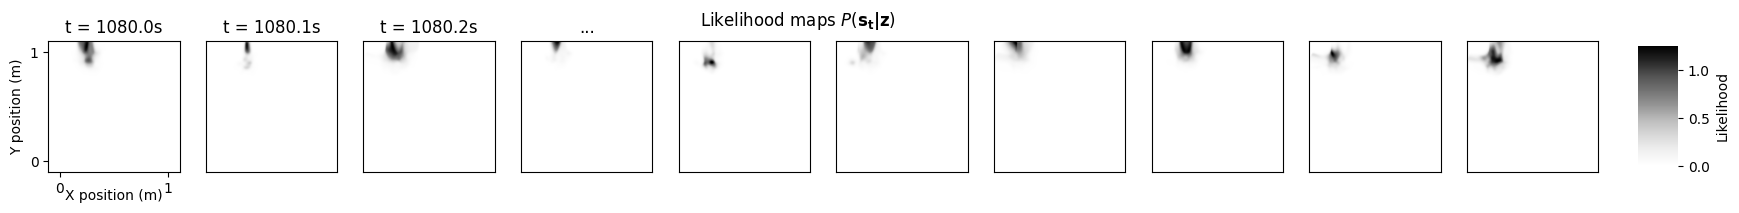

In [12]:
# Plot them
fig = plt.figure(figsize=(20, 2))
for i in range(0,10):
    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    im = ax.imshow(likelihood_maps[i], origin='lower', extent=env_extent, cmap='Greys', aspect='equal')
    ax.set_title(f"{f't = {T_test[i]:.1f}s' if i <= 2 else f'{'...' if i == 3 else ''}'}")
    if i == 0:
        ax.set_xticks([min_x.round(1), max_x.round(1)]); ax.set_yticks([min_y.round(1), max_y.round(1)])
        ax.set_xlabel("X position (m)", labelpad=-5); ax.set_ylabel("Y position (m)")
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6], frameon=False)
fig.colorbar(im, cax=cax, label="Likelihood");
fig.suptitle(r"Likelihood maps $P(\mathbf{s_{t} | \mathbf{z}})$"); 

### 2.2 Fit Gaussians to likelihoods

The goal is to approximate these (potentially complex and multimodal) likelihood maps with a Gaussian: 

$$P(\mathbf{x}_{t} | \mathbf{z}) \approx  A \exp\Big[{-\frac{1}{2}(\mathbf{z}-\boldsymbol{\mu}_t)^{\mathsf{T}}\boldsymbol{\Sigma}_{t}^{-1}(\mathbf{z}-\boldsymbol{\mu}_t)}\Big]$$

**Why are we doing this?** In the next section we want to use a Kalman filter to _estimate_ position from spiking data. A core assumption of the Kalman model is the "observations" of a system are (noisy) linear functions of the state. Our guess is that _spike count vectors are **not** noisey linear functions of position__ but that _the mean (or perhaps mode) of the likelihood maps may approximately be_. 

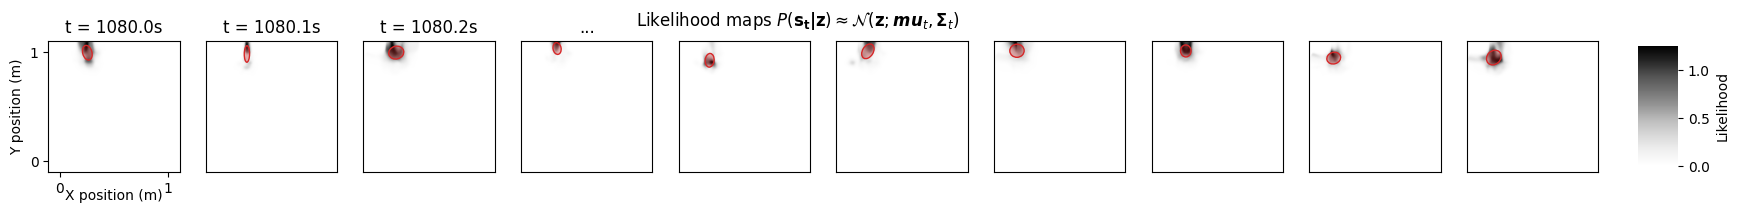

In [13]:
# Calculate the means, modes and covariances of the fitted Gaussians
MLE_means, MLE_modes, MLE_covs = vmap(fit_gaussian, in_axes=(None, 0))(bin_positions, likelihoods)
MLE_means_train, MLE_modes_train, MLE_covs_train = vmap(fit_gaussian, in_axes=(None, 0))(bin_positions, likelihoods_train)


for (i,ax) in enumerate(fig.get_axes()[:-1]):
    lambda_, v = np.linalg.eig(MLE_covs[i])
    lambda_ = np.sqrt(lambda_)
    ax.plot(MLE_means[i][0], MLE_means[i][1], c='r', markersize=5)
    ell = matplotlib.patches.Ellipse(xy=MLE_means[i],
                                     width=lambda_[0]*2, 
                                     height=lambda_[1]*2, 
                                     angle=np.rad2deg(np.arctan(v[:, 0][1] / v[:, 0][0])),
                                     lw=1, 
                                     fill=True, 
                                     edgecolor='C3',
                                     facecolor=matplotlib.colors.to_rgba('C3', alpha=0.3))
    ax.add_artist(ell)
fig.suptitle(r"Likelihood maps $P(\mathbf{s_{t} | \mathbf{z}}) \approx \mathcal{N}(\mathbf{z} ; \boldsymbol{mu}_t, \boldsymbol{\Sigma}_t)$")
fig.savefig("figures/likelihood_maps_fitted.png", dpi=300)
fig

### 2.3 Inference via Kalman filter
Let $\mathbf{z}_t$ represents the "state" of the system (its latent position) and assume it evolves according to a linear dynamical system with Gaussian noise. $\mathbf{y}_t$ represents an "observation" of the system (here, the mode of the likelihood map at time $t$) and is a noisy linear function of the state.
$$\mathbf{z}_{t} = \mathbf{F}_t \mathbf{z}_{t-1} + \mathbf{q}_t$$
$$\mathbf{y}_{t} = \mathbf{H}_t \mathbf{z}_{t} + \mathbf{r}_t$$
where $\mathbf{q}_t \sim \mathcal{N}(0, \mathbf{Q}_t)$ and $\mathbf{r}_t \sim \mathcal{N}(0, \mathbf{R}_t)$ are the process and observation noise respectively. 

The Kalman filter is an efficient recursive solution to the problem of estimating the posterior distribution of the state given the observations. Since the initial state distribution is Gaussian and the dynamics / observation models are linear with Gaussian noise, the _posterior_ distribution at each time step is also Gaussian and can be computed recursively very fast using the Kalman filter equations (can be found in any textbook, I match the notation to [Chapter 8.2, Probabilistic Machine Learning (Advanced Topics), Kevin Murphy](https://probml.github.io/pml-book/book2.html)). 

Strictly, Kalman "filtering" calculates the posterior distribution of the state given only the observations up to that time. Kalman "smoothing" calculates the posterior distribution of the state given all the observations.

$$P(\mathbf{z}_t | \mathbf{y}_{1:t}) = \mathcal{N}(\mathbf{z}_t | \boldsymbol{\mu}^{F}_t, \boldsymbol{\Sigma}^{F}_t)$$
$$P(\mathbf{z}_t | \mathbf{y}_{1:T}) = \mathcal{N}(\mathbf{z}_t | \boldsymbol{\mu}^{S}_t, \boldsymbol{\Sigma}^{S}_t)$$


#### 2.3.1 Optimal _stationary_ parameters of the Kalman filter
For time-constant dynamics/observations the Kalman filter can be fit by maximum likelihood (exploiting/assuming the fact that $\mathbf{z}_t$ is known during training). The parameters $\Theta = \{\mathbf{F}, \mathbf{Q}, \mathbf{H}, \mathbf{R}\}$ which maximise the likelihood of the data under the model $\mathcal{L}(\Theta) = \log P(\mathbf{S}, \mathbf{Z} | \Theta)$ are relatively easily computed as: 

\begin{align}
\mathbf{F} &= \Big( \sum_{t=2}^{T} \mathbf{z}_{t-1} \mathbf{z}_{t}^{\mathsf{T}} \Big) \Big( \sum_{t=2}^{T} \mathbf{z}_{t-1} \mathbf{z}_{t-1}^{\mathsf{T}} \Big)^{-1} &\approx \mathbf{I}\\
\mathbf{Q} &= \frac{1}{T-1} \sum_{t=2}^{T} (\mathbf{z}_{t} - \mathbf{F} \mathbf{z}_{t-1})(\mathbf{z}_{t} - \mathbf{F} \mathbf{z}_{t-1})^{\mathsf{T}} &\approx (v_{\textrm{typical}}\cdot dt)^{2}\mathbf{I}\\
\mathbf{H} &= \Big( \sum_{t=1}^{T} \mathbf{z}_{t} \mathbf{y}_{t}^{\mathsf{T}} \Big) \Big( \sum_{t=1}^{T} \mathbf{y}_{t} \mathbf{y}_{t}^{\mathsf{T}} \Big)^{-1} & \approx \mathbf{I}\\
\mathbf{R} &= \frac{1}{T} \sum_{t=1}^{T} (\mathbf{z}_{t} - \mathbf{H} \mathbf{y}_{t})(\mathbf{z}_{t} - \mathbf{H} \mathbf{y}_{t})^{\mathsf{T}}  & \approx \sigma_Y^{2}\mathbf{I}
\end{align}

These are implemented by the `Kalman.fit_parameters()` function.

#### 2.3.2 Naïve Kalman filtering (spike counts as observations)
The most basic Kalman filter is the one where the observations are the spike counts themselves and the parameters are stationary. We're ready to run this now.

$$\mathbf{y}_t = \mathbf{s}_t \hspace{1cm} \textrm{Naive Kalman}$$

(100, 2) (100, 2, 2) (100, 2, 2) (100, 2, 2)


Text(0.5, 1.0, 'Naive Kalman results')

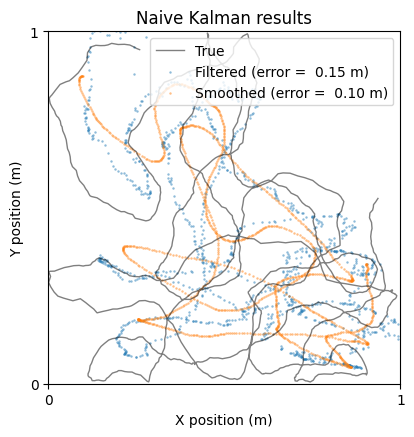

In [14]:
# Observations = spikes
Y = S_test 

# Fit the parameters
mu0, sigma0, F, Q, H, R = fit_parameters(Z_train, S_train) 

# Create the Kalman Filter
kalman_filter = KalmanFilter(dim_Z = DIMS, 
                             dim_Y = N_CELLS,
                             F=F, 
                             Q=Q, 
                             H=H,
                             R=R,)

# Filter the test observations 
mus_f, sigmas_f = kalman_filter.filter(
                     Y = Y, 
                     mu0 = mu0,
                     sigma0 = sigma0,)

# Smooth the test observations 
mus_s, sigmas_s = kalman_filter.smooth(
                    mus_f = mus_f, 
                    sigmas_f = sigmas_f)


# Plot the results
def plot_decoding_results(ax, results_dict):
    for (key, val) in results_dict.items():
        if key != 'True':
            error = f" (error = {jnp.linalg.norm(val - results_dict['True'], axis=1).mean() : .2f} m)"
            ax.scatter(val[:,0], val[:,1], label=key + error, linewidth=0, alpha=0.5, s=3, color=('r' if key=='True' else None))
        else: 
            ax.plot(val[:,0], val[:,1], label=key, color='k', alpha=0.5, lw=1)
    ax.legend()
    ax.set_xlim(min_x, max_x); ax.set_ylim(min_y, max_y); ax.set_aspect('equal', 'box')
    ax.set_xticks([min_x.round(1), max_x.round(1)]); ax.set_yticks([min_y.round(1), max_y.round(1)])
    ax.set_xlabel("X position (m)"); ax.set_ylabel("Y position (m)")
    
    return ax

results_dict = {'True': Z_test,
                'Filtered': mus_f,
                'Smoothed': mus_s}

fig = plt.figure(figsize=(10, 5))
# add figure in left half 
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax = plot_decoding_results(ax, results_dict)
ax.set_title("Naive Kalman results")

#### 2.3.3 KalMax Kalman filtering (MLE as observations with time-varying noise)

Naive Kalman filtering is pretty bad, essentially because the observations (spike count vectors) are not linear functions of the state. 

**MLE as observations**: Instead we could smooth the maximum likelihood (or any other summary statistic of the likelihood map).

\begin{align}
\mathbf{z}_t^{MLE} &= \arg\max_{\mathbf{z}} P(\mathbf{s}_t | \mathbf{z}) \hspace{1cm} \textrm{(or any other reasonable summary statistic)} \\
\mathbf{y}_t &= \mathbf{z}^{MLE}_{t} \hspace{4cm} \textrm{KalMax Kalman}
\end{align}

**Time varying observation noise** Also, we might be able to do better than the stationary parameters by letting the observation noise $\mathbf{R}$ vary with time according to the variance of the likelihood maps: 

$$\mathbf{R}_t = \boldsymbol{\Sigma}_{t}$$

The intuition is that when the likelihood maps are very broad (uncertain) -- probably because few/no spikes were observed in this bin, or because the spikes which were observed came from cells with broad and therefore uninformative receptive fields --  we should trust the observations less and vice versa. In `Kalman.KalmanFilter`, parameters which are passed in at initialisation are assumed stationary. Parameters which are passed in at `.filter()` or `.smooth()` time are assumed to vary with time.

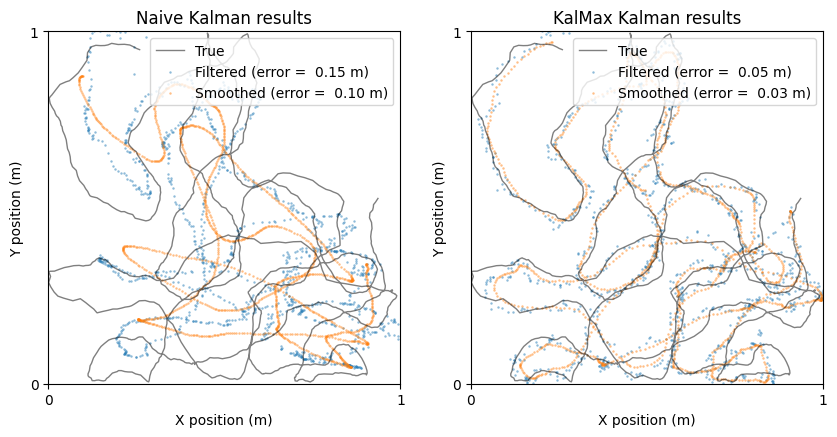

In [15]:
# Observations = spikes
Y = MLE_modes

# Fit the parameters
mu0, sigma0, F, Q, H, R = fit_parameters(Z_train, MLE_modes_train) 

# Create the Kalman Filter
kalman_filter = KalmanFilter(dim_Z = DIMS, 
                             dim_Y = DIMS,
                             F=F, 
                             Q=Q, 
                             H=H,
                             R=None, # R is time varying so we don't set it here
                             )

# Filter the test observations 
mus_f, sigmas_f = kalman_filter.filter(
                     Y = Y, 
                     mu0 = mu0,
                     sigma0 = sigma0,
                     R=MLE_covs
                     )

# Smooth the test observations 
mus_s, sigmas_s = kalman_filter.smooth(
                    mus_f = mus_f, 
                    sigmas_f = sigmas_f)


# Plot the results
results_dict = {'True': Z_test,
                'Filtered': mus_f,
                'Smoothed': mus_s}
ax1 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax1 = plot_decoding_results(ax1, results_dict)
ax1.set_title("KalMax Kalman results")
fig.savefig("figures/kalmax.png", dpi=300)
fig